In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

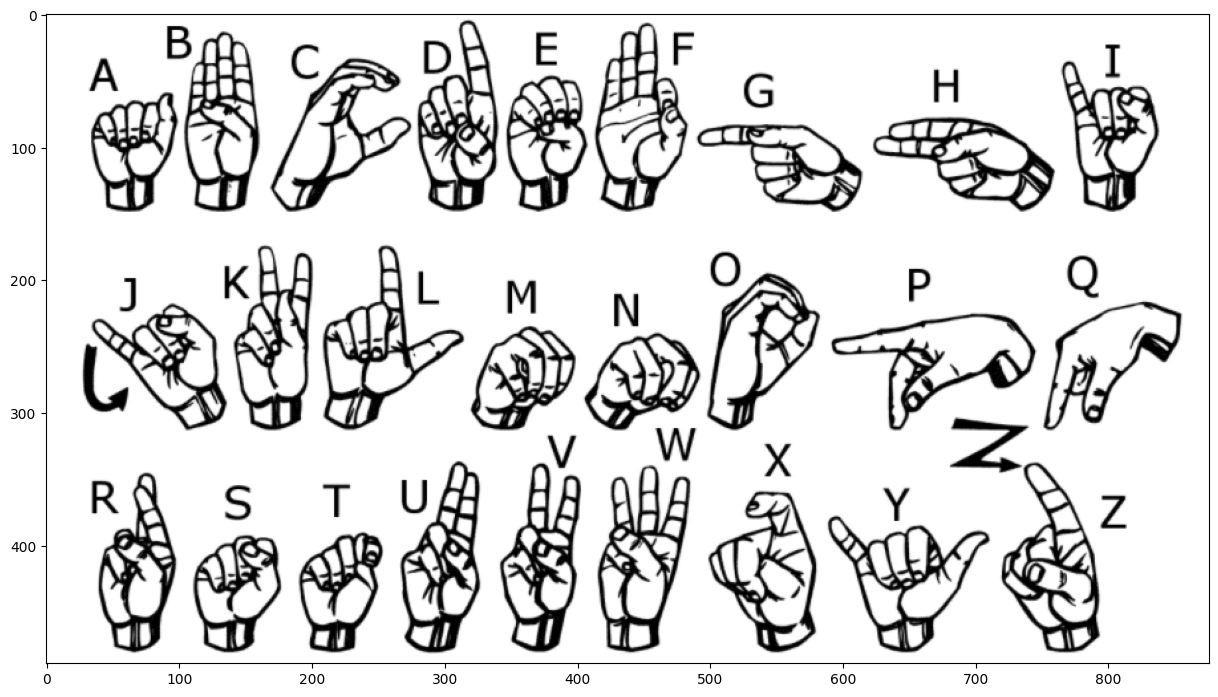

In [4]:
img = mpimg.imread("/content/american_sign_language.png")
plt.figure(figsize = (15, 12))
plt.imshow(img)

In [5]:
sig_labels = {}
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range (26):
    sig_labels[i] = letras[i]

In [6]:
train_val_set = pd.read_csv("/content/sign_mnist_train.csv")

train_val_y_df = train_val_set["label"]
train_val_X_df = train_val_set.drop("label", axis = "columns")

train_val_y = train_val_y_df.to_numpy()
train_val_X = train_val_X_df.to_numpy()

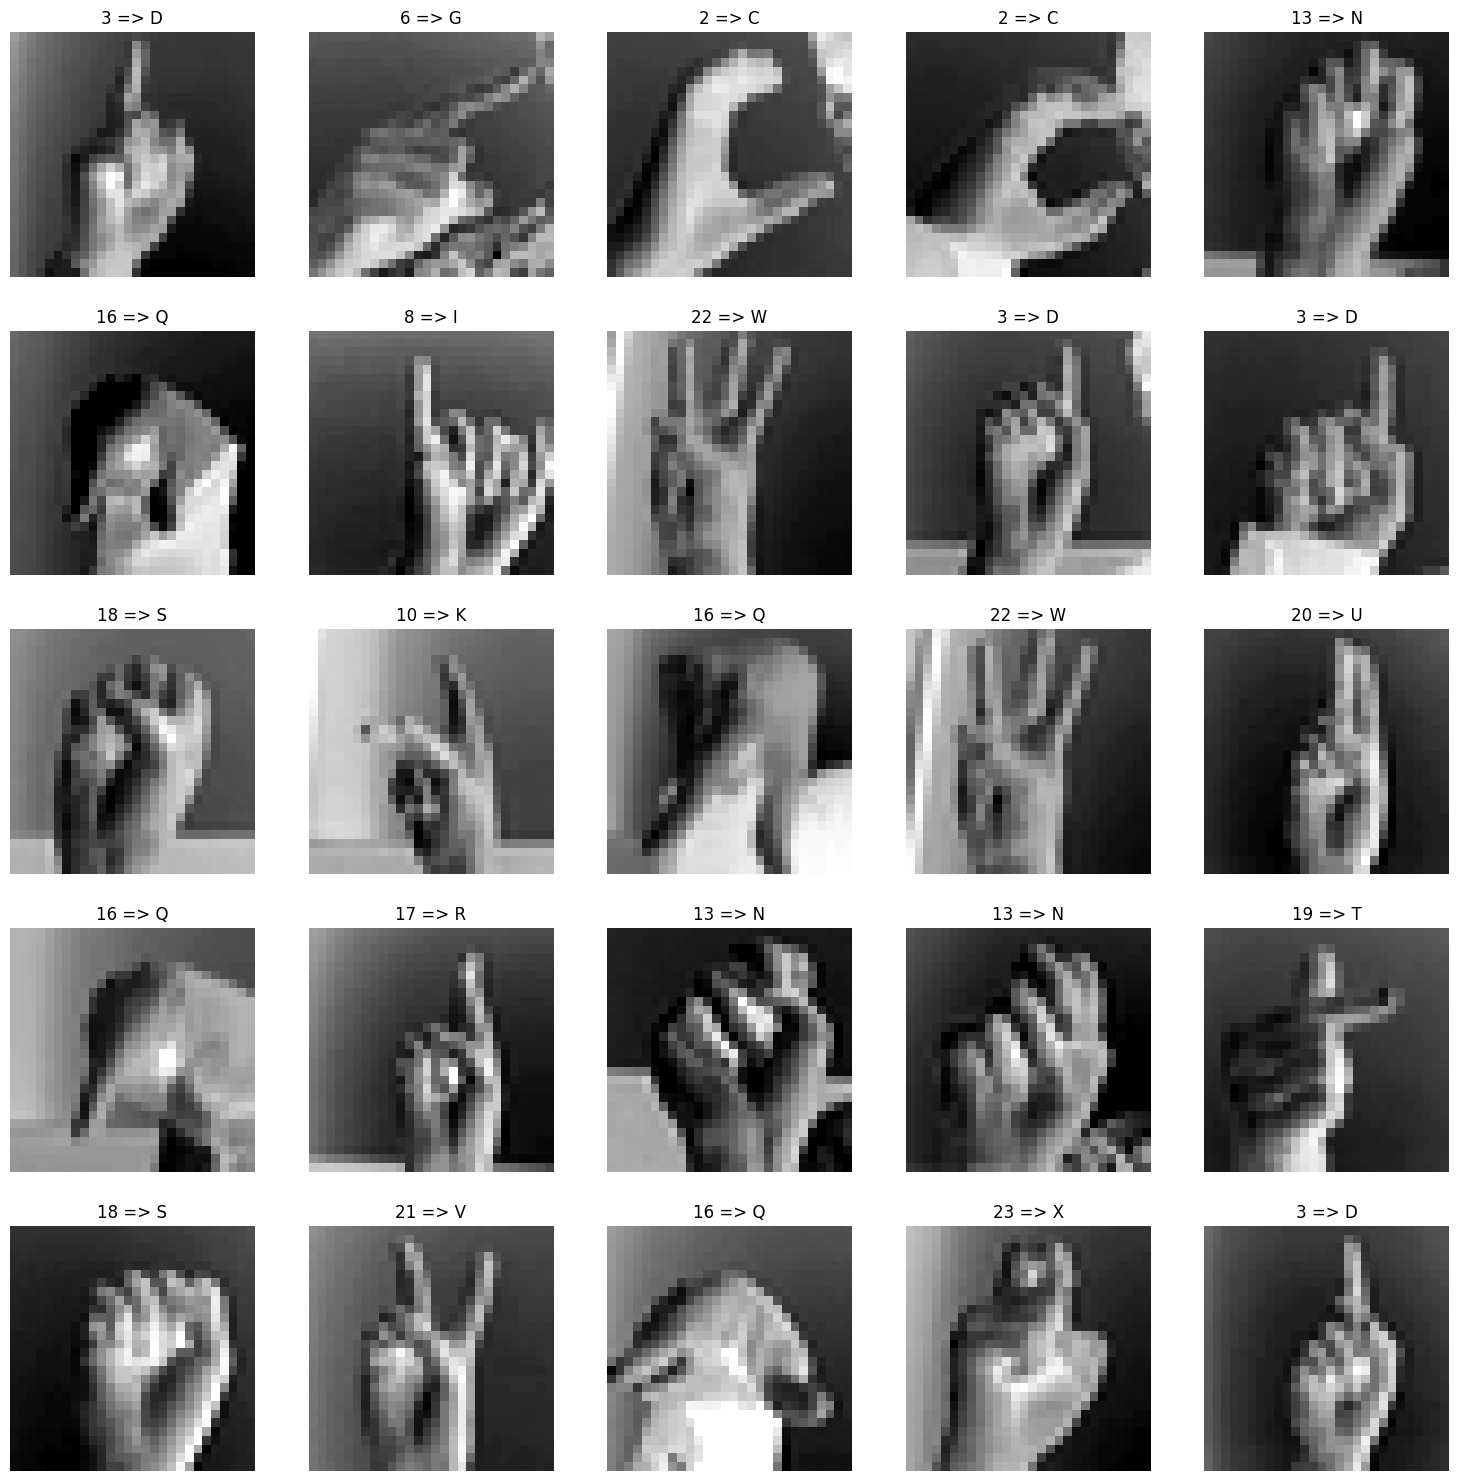

In [7]:
examples25 = train_val_X[0 : 25]

figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0 # row
contc = 0 # column
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(examples25[i].reshape(28, 28), cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(train_val_y[i], sig_labels[train_val_y[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

In [9]:
train_val_X_for_extension = train_val_X.reshape(27455, 28, 28, 1).copy()

In [11]:
datagen1 = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = 0.1)
X_new_1_raw = datagen1.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

datagen2 = ImageDataGenerator(rotation_range = 20)
X_new_2_raw = datagen2.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

In [12]:
X_new_1 = X_new_1_raw[0].copy()
X_new_2 = X_new_2_raw[0].copy()

In [13]:
X_train_val_extended = np.concatenate((train_val_X_for_extension, X_new_1, X_new_2), axis = 0)
y_train_val_extended = np.concatenate((train_val_y, train_val_y, train_val_y))

In [14]:
X_train_val_extended.shape, y_train_val_extended.shape

((82365, 28, 28, 1), (82365,))

In [ ]:
figs, axs = plt.subplots(15, 3, figsize = (8, 30))
contf = 0
contc = 0

for i in range(15):

    axs[i, 0].imshow(X_train_val_extended[i], cmap = mpl.cm.binary)
    axs[i, 0].axis("off")

    axs[i, 1].imshow(X_train_val_extended[27455 + i], cmap = mpl.cm.binary)
    axs[i, 1].axis("off")

    axs[i, 2].imshow(X_train_val_extended[27455 * 2 + i], cmap = mpl.cm.binary)
    axs[i, 2].axis("off")

    axs[i, 0].set_title("Original => %s" %(y_train_val_extended[i]))
    axs[i, 1].set_title("1st modification => %s" %(y_train_val_extended[27455 + i]))
    axs[i, 2].set_title("2nd modification => %s" %(y_train_val_extended[27455 * 2 + i]))


In [16]:
X_train_val_sf , y_train_val_sf = shuffle(X_train_val_extended, y_train_val_extended)

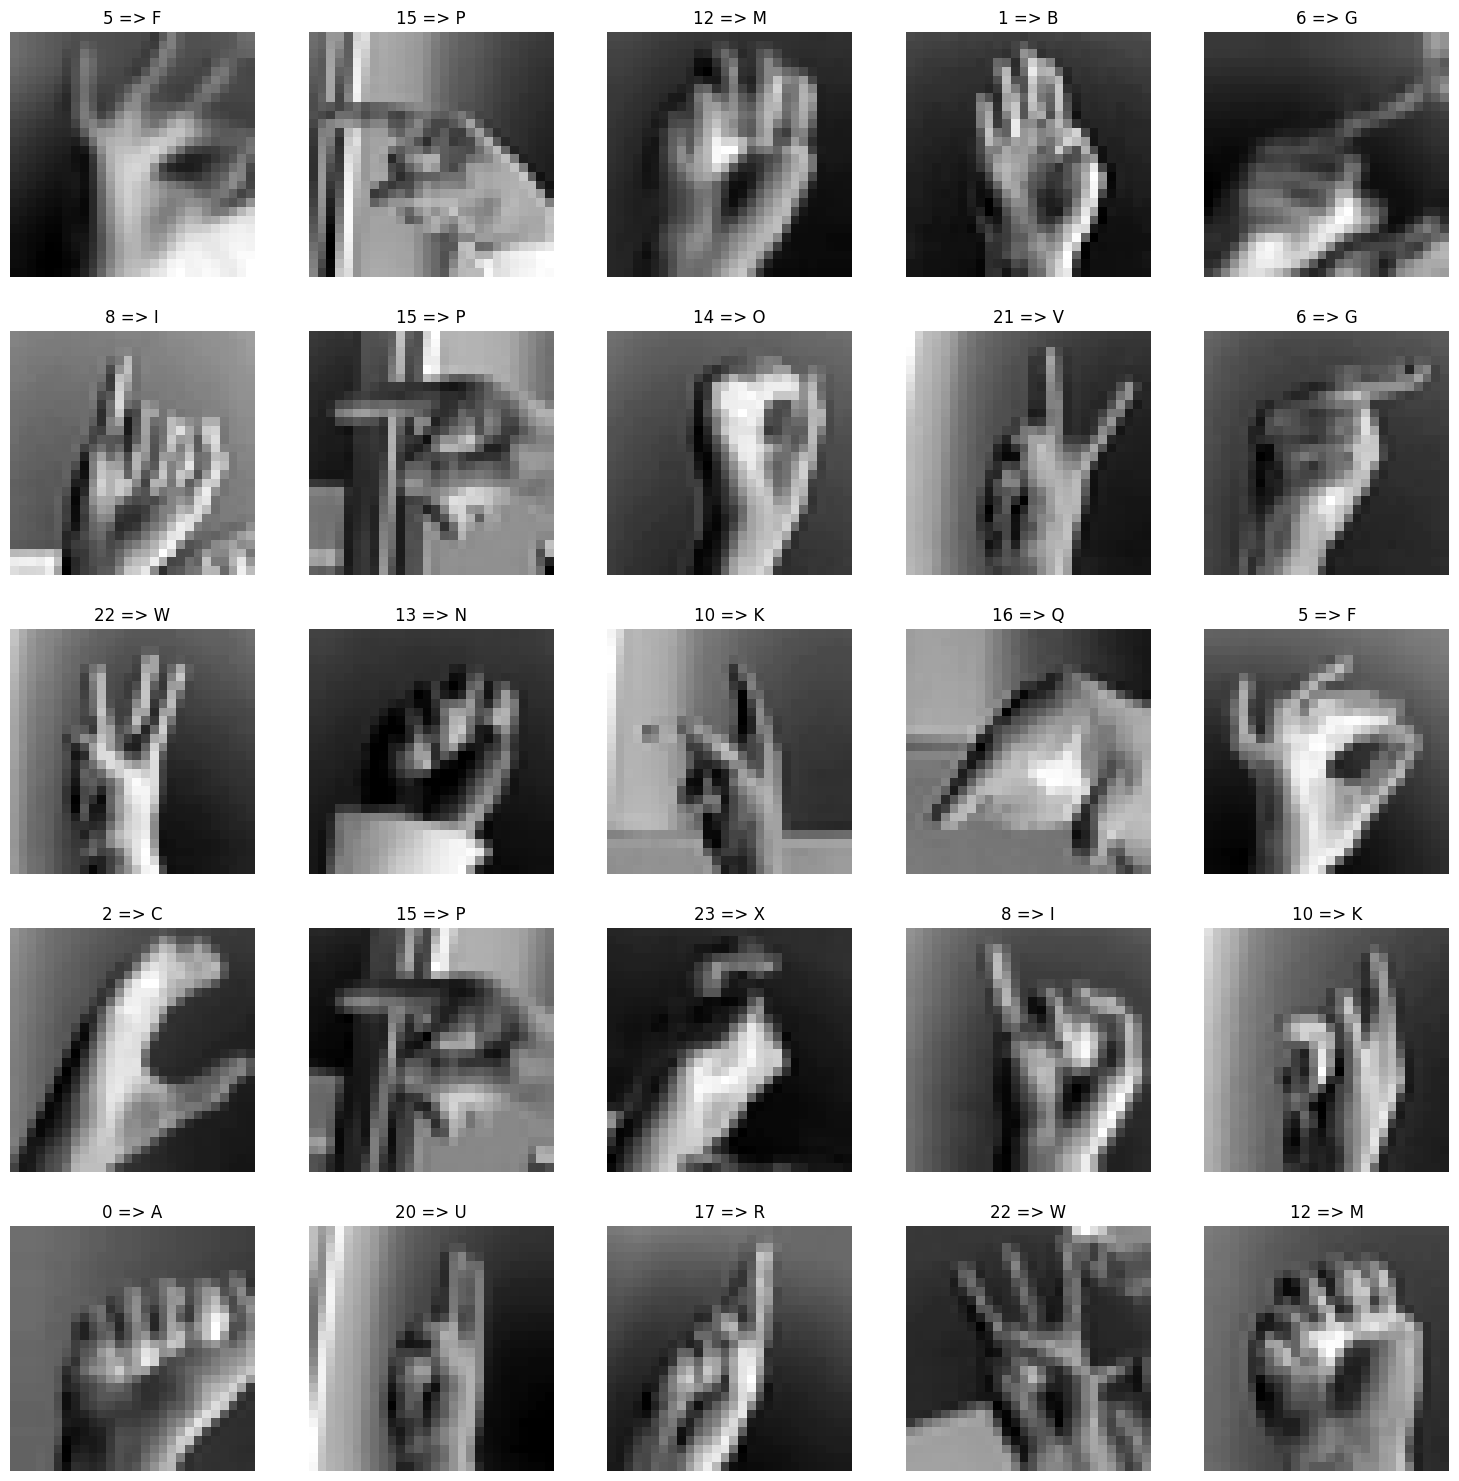

In [17]:
figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0
contc = 0
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(X_train_val_sf[i], cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(y_train_val_sf[i], sig_labels[y_train_val_sf[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

In [18]:
X_train = X_train_val_sf[0 : 75000].copy().reshape(75000, 784) / 255.0
y_train = y_train_val_sf[0 : 75000].copy()

X_val = X_train_val_sf[75000 : ].copy().reshape(82365 - 75000, 784) / 255.0
y_val = y_train_val_sf[75000 :].copy()

In [19]:
forest_clf = RandomForestClassifier(n_estimators = 646, max_depth = 19,
                                    criterion = "entropy", bootstrap = True)

In [20]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=19, n_estimators=646)

In [21]:
pred_forest_train = forest_clf.predict(X_train)
pred_forest_val = forest_clf.predict(X_val)


In [22]:
def accuracy_calculator(pred1, pred2):

    sum = 0
    for i in range(len(pred1)):
        if pred1[i] == pred2[i]:
            sum += 1
    return sum/(len(pred1))

In [23]:
accuracy_calculator(y_train, pred_forest_train), accuracy_calculator(y_val, pred_forest_val)

(1.0, 0.9494908350305499)

In [24]:
test_set = pd.read_csv("/content/sign_mnist_test.csv")

test_y_df = test_set["label"]
test_X_df = test_set.drop("label", axis = "columns")

test_y = test_y_df.to_numpy()
test_X = test_X_df.to_numpy()

In [25]:
test_X.shape, test_y.shape

((7172, 784), (7172,))

In [26]:
X_test = test_X.copy() / 255.0
y_test = test_y.copy()


In [27]:
pred_forest_test = forest_clf.predict(X_test)


In [28]:
accuracy_calculator(y_test, pred_forest_test)


0.9078360290016732

In [29]:
conf_mx = confusion_matrix(y_test, pred_forest_test)

In [30]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

<ipython-input-31-bb324b6a06a4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-31-bb324b6a06a4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


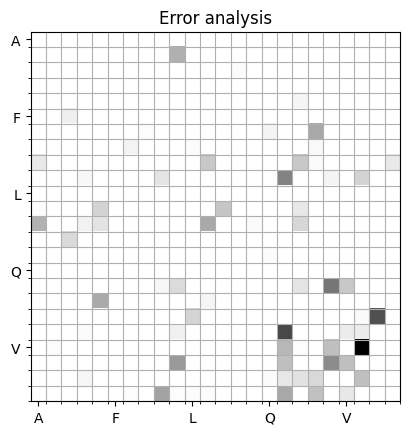

<Figure size 2000x2000 with 0 Axes>

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(norm_conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("Error analysis")
plt.figure(figsize = (20, 20))
plt.show()

<ipython-input-32-10071d5b1a09>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-32-10071d5b1a09>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


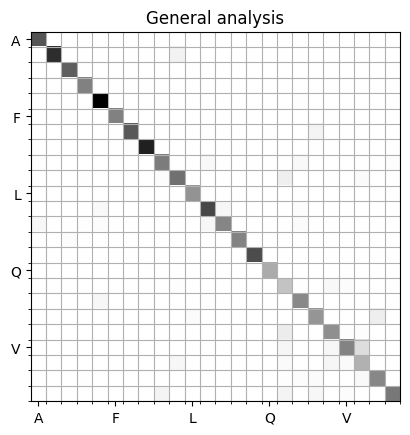

<Figure size 2000x2000 with 0 Axes>

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("General analysis")
plt.figure(figsize = (20, 20))
plt.show()